In [159]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfl = tfk.layers
tfd = tfp.distributions
tfs = tf.summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [195]:
batch_size = 128
buffer_size = 500

def normalise_image(img):
    return tf.cast(img, tf.float32) / 255.

train_dataset = tfds.load(name="mnist", split=tfds.Split.TRAIN)
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).repeat()
train_dataset = train_dataset.map(lambda x: x['image'])
train_dataset = train_dataset.map(normalise_image)
train_dataset = train_dataset.batch(batch_size)

In [238]:
class Encoder(tfl.Layer):
    
    def __init__(self, latent_size, name='encoder', **kwargs):
        
        self.latent_size = latent_size
        
        super(Encoder, self).__init__(name=name, **kwargs)
        
    
    def build(self, input_shape):
        
        self.layers = [
            
            tfl.Conv2D(filters=32,
                       kernel_size=(5, 5),
                       padding='same'),
            
            tf.nn.relu,
            
            tfl.Conv2D(filters=64,
                       kernel_size=(5, 5),
                       strides=(2, 2),
                       padding='same'),
            
            tf.nn.relu,
            
            tfl.Conv2D(filters=128,
                       kernel_size=(5, 5),
                       strides=(2, 2),
                       padding='same'),
            
            tf.nn.relu,
            
            tfl.Reshape((7 * 7 * 128,)),
            
            tfl.Dense(128),
            
            tf.nn.relu
        ]
        
        self.loc_head = tfl.Dense(self.latent_size)
        
        self.log_scale_head = tfl.Dense(self.latent_size)
    
    
    def call(self, tensor):
        
        for layer in self.layers:
            tensor = layer(tensor)
            
        loc = self.loc_head(tensor)
        scale = tf.nn.softplus(self.log_scale_head(tensor))
    
        self.posterior = tfd.Normal(loc=loc, scale=scale)
        
        return self.posterior.sample()
    
    
class Decoder(tfl.Layer):
    
    def __init__(self, name='decoder', **kwargs):
        
        super(Decoder, self).__init__(name=name, **kwargs)
        
    
    def build(self, input_shape):
        
        self.layers = [
            
            tfl.Dense(128),
            
            tf.nn.relu,
            
            tfl.Dense(7 * 7 * 128),
            
            tf.nn.relu,
            
            tfl.Reshape((7, 7, 128)),
            
            tfl.Conv2DTranspose(filters=64,
                                kernel_size=(5, 5),
                                strides=(2, 2),
                                padding='same'),
            
            tf.nn.relu,
            
            tfl.Conv2DTranspose(filters=32,
                                kernel_size=(5, 5),
                                strides=(2, 2),
                                padding='same'),
            
            tf.nn.relu,
            
            tfl.Conv2DTranspose(filters=1,
                                kernel_size=(5, 5),
                                padding='same'),
            
            tf.nn.sigmoid
            
        ]
    

    def call(self, tensor):
        
        for layer in self.layers:
            tensor = layer(tensor)
        
        return tensor
    
    
class VAE(tfk.Model):
    
    def __init__(self, latent_size, name='vae', **kwargs):
        
        self.latent_size = latent_size
        
        super(VAE, self).__init__(name=name, **kwargs)
        
        
    @property
    def log_prob(self):
        
        return tf.reduce_mean(self._log_prob)
    
    @property
    def kl_divergence(self):
        
        kl_each_latent = tfd.kl_divergence(self.posterior, self.prior)
        
        kl_each_example = tf.reduce_sum(kl_each_latent, axis=-1)
        
        return tf.reduce_mean(kl_each_example)
    
    @property
    def posterior(self):
        
        return self.encoder.posterior
    
    
    def build(self, input_shape):
        
        self.encoder = Encoder(self.latent_size)
        self.decoder = Decoder()

        self.prior = tfd.Normal(loc=tf.zeros(self.latent_size),
                                scale=tf.ones(self.latent_size))
    
    
    def call(self, tensor):
        
        latents = self.encoder(tensor)
        
        loc = self.decoder(latents)
        
        self.likelihood = tfd.Normal(loc=loc, scale=0.3)
        self._log_prob = tf.reduce_sum(self.likelihood.log_prob(tensor), axis=(1, 2, 3))
        
        return loc

In [240]:
train_steps = 4000
beta = 1e0
learn_rate = 1e-3
log_freq = 10

vae = VAE(2)

optimizer = tfk.optimizers.Adam(learn_rate)

train_summary_writer = tfs.create_file_writer('summaries/train')

with train_summary_writer.as_default():

    for batch in tqdm(train_dataset.take(train_steps), total=train_steps):
        
        with tf.GradientTape() as tape:

            reconstructions = vae(batch)

            neg_elbo = - vae.log_prob + beta * tf.reduce_sum(vae.kl_divergence)

        gradients = tape.gradient(neg_elbo, vae.trainable_variables)

        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

        if tf.equal(optimizer.iterations % log_freq, 0):

            tfs.scalar('Negative-ELBO', neg_elbo, step=optimizer.iterations)
            tfs.image('Original', batch, step=optimizer.iterations)
            tfs.image('Reconstruction', reconstructions, step=optimizer.iterations)

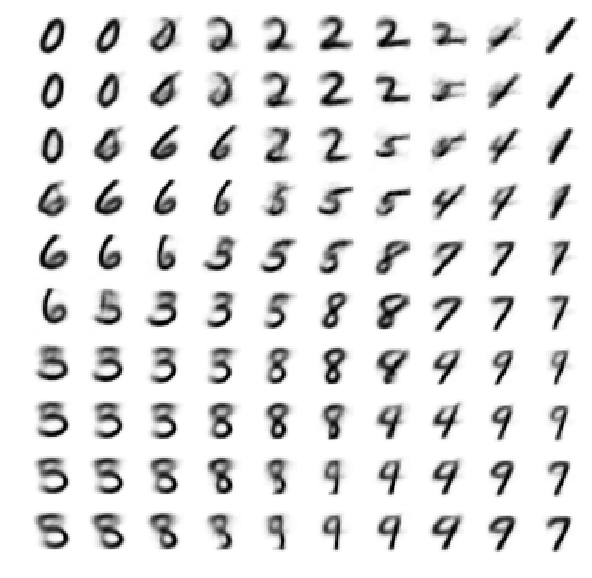

In [268]:
grid_latents = tf.stack(tf.meshgrid(tf.linspace(-1., 1., 10), tf.linspace(-1., 1., 10)), axis=-1)

grid_latents = tf.reshape(grid_latents, (-1, 2))

images = tf.reshape(vae.decoder(grid_latents), (10, 10, 28, 28)).numpy()

fig = plt.figure(figsize=(10, 10))

for i in range(100):
    
    subfig = fig.add_subplot(10, 10, i + 1)
    subfig.imshow(images[i // 10, i % 10, :, :], cmap='binary')
    
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()